In [1]:
import csv
import re
import pathlib
import torch

epoch_pattern = re.compile(r"^starting epoch:\s*(\d+)")
starting_pattern = re.compile(r"^Starting training.*")
train_metrics_pattern = re.compile(r"Train -\s+loss:\s*([\d.]+)\s+top-1:\s*([\d.]+)\s+top-5:\s*([\d.]+)\s+top-10:\s*([\d.]+)")
eval_metrics_pattern = re.compile(r"Eval -\s+loss:\s*([\d.]+)\s+top-1:\s*([\d.]+)\s+top-5:\s*([\d.]+)\s+top-10:\s*([\d.]+)")

name_var_pattern = re.compile(r"-?((?P<varname>[a-zA-Z\-_]+)=(?P<value>\-?\d+\.?\d*(e\-?\d+)?))")
name_pattern = re.compile(r"^(?P<exp_group>[\d]+)?\-?(?P<Layer>.+)(?P<Position>Pre|Post|Both)(?P<DyTfn>.*tanh)?(?P<Vars>(([a-zA-Z\-_]+)=([\d\.e\-]+))*)$")

def read_grad_l2(pth_file):
    grads = torch.load(pth_file)

    sections = {".".join(key.split('.')[4:]) for key in grads.keys() if len(key.split('.')) >= 4}

    grads_l2 = {key: [] for key in sections}
    for i, key in enumerate(grads.keys()):
        section = key.split(".")
        if len(section) < 3:
            continue
        section = ".".join(section[4:])
        grads_l2[section].append(torch.norm(grads[key], p=2).item())
        
    return grads_l2


def parse_name(name):
    out = {"exp_group":1, 'lr':1e-4, 'dim_hidden':256}
    search = name_pattern.search(name)
    if search is None:
        out["Layer"] = "Identity"
        out["Position"] = "Both"
        return out
    out["Layer"] = search.group("Layer")
    if out["Layer"]=="DyT":
        out["Alpha"] = 0.5
        out["DyTfn"] = "Tanh"
    out["Position"] = search.group("Position")
    if search.group("DyTfn") is not None:
        out["DyTfn"] = search.group("DyTfn")
    if search.group("exp_group") is not None:
        out["exp_group"] = int(search.group("exp_group"))
    out.update({e[1]:float(e[2]) for e in name_var_pattern.findall(search.group("Vars"))})
    return out

def read_log(folder):
    data_rows = []
    current_epoch = None
    train_metrics = {}
    eval_metrics = {}
    english = None
    french = None
    current_model = folder.name
    smallest_epoch = None
    
    with open(folder/"training_logs.log", "r", encoding="utf-8") as f:
        current_model_data = []
        for line in f.readlines():
            line = line.strip()
            
            if match := starting_pattern.match(line):
                continue

            if match := epoch_pattern.match(line):
                if smallest_epoch is None:
                    smallest_epoch = int(match.group(1))
                current_epoch = int(match.group(1))-smallest_epoch
                continue

            if match := train_metrics_pattern.match(line):
                train_metrics = {
                    "Train Loss": float(match.group(1)),
                    "Train Top-1": float(match.group(2)),
                    "Train Top-5": float(match.group(3)),
                    "Train Top-10": float(match.group(4)),
                }
                continue

            if match := eval_metrics_pattern.match(line):
                eval_metrics = {
                    "Eval Loss": float(match.group(1)),
                    "Eval Top-1": float(match.group(2)),
                    "Eval Top-5": float(match.group(3)),
                    "Eval Top-10": float(match.group(4)),
                }
                continue

            if english is None:
                english = line
                continue
            elif french is None:
                french = line
                row = {
                    **parse_name(current_model),
                    "Exp_full_name": current_model,
                    "Epoch": current_epoch,
                    "Ground Truth": english,
                    "Prediction": french,
                    **train_metrics,
                    **eval_metrics,
                    "grads":read_grad_l2(folder/f"grads_epoch_start_epoch_{current_epoch}.pth")
                }
                current_model_data.append(row)
                english = None
                french = None
                continue
            
    data_rows.extend(current_model_data)
    current_model_data = []
    return data_rows


In [2]:

import matplotlib.pyplot as plt
import math
import copy
import numpy as np

def make_fig_axes(name="", ncols=4, nrows = 7, figsize=(20, 16)):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    fig.suptitle(name)
    return fig, axes

def plot_multiple_grads(df, name="", name_fn=lambda row: row[0], ncols=4, figsize=(20, 16)):
    keys = set()
    for grad in df["grads"]:
        keys.update(grad.keys())
    fig, axes =  make_fig_axes(name=name, ncols=ncols, nrows=int(math.ceil(len(keys)/ncols)), figsize=figsize)
    grads = []
    for grad in df["grads"]: 
        grad = copy.deepcopy(grad)

        grad["Transformer Complet"] = list(np.array([v for v in grad.values()]).mean(axis=0))
        for key in keys:
            grad[key] = grad.get(key, None)
        
        grads.append(grad)
    
    legend = []
    for row in df.iterrows():
        legend.append(name_fn(row))

    for grad, row in zip(grads, df.iterrows()):
        fig, axes = plot_grads(grad, fig, axes, legend)
    plt.tight_layout()
    return fig, axes


def plot_grads(grads, fig=None, axes=None, legend=None):
    model_sections = [key for key in grads.keys() if grads[key] is None or len(grads[key]) > 0]
    if fig is None or axes is None:
        fig, axes = make_fig_axes()
    nrows, ncols = axes.shape
    for i, key in enumerate(model_sections):
        if grads[key] is None:
            continue
        ax = axes[i // ncols, i % ncols]
        ax.plot(grads[key])
        ax.set_xlabel('Couche')
        ax.set_ylabel('Gradient l2')
        ax.set_title(key)
        if legend is not None:
            ax.legend(legend)

    plt.tight_layout()
    return fig, axes

In [3]:
runs = [e for e in pathlib.Path("logs").glob("*") if e.is_dir()]

In [4]:
logs = []
for e in runs: 
    logs += read_log(e)

In [5]:
data = {k:[] for e in logs for k in e.keys()}

for e in logs:
    for k in data.keys():
        data[k].append(e.get(k))


In [6]:
import pandas as pd

In [17]:
cols = ["Layer","Position","Epoch","Train Loss","Eval Loss","Alpha","DyTfn","exp_group","lr","dim_hidden","Exp_full_name","Ground Truth","Prediction","Train Top-1","Train Top-5","Train Top-10","Eval Top-1","Eval Top-5","Eval Top-10", "grads"]

df = pd.DataFrame(data, columns=cols)
df.to_csv("out.csv", index=False)


(<Figure size 2000x1600 with 20 Axes>,
 array([[<Axes: title={'center': 'normffpost.weight'}, xlabel='Couche', ylabel='Gradient l2'>,
         <Axes: title={'center': 'crossattn.Wq.weight'}, xlabel='Couche', ylabel='Gradient l2'>,
         <Axes: title={'center': 'crossattn.Wk.weight'}, xlabel='Couche', ylabel='Gradient l2'>,
         <Axes: title={'center': 'selfattn.Wv.weight'}, xlabel='Couche', ylabel='Gradient l2'>],
        [<Axes: title={'center': 'normselfattnpost.alpha'}, xlabel='Couche', ylabel='Gradient l2'>,
         <Axes: title={'center': 'crossattn.Wv.weight'}, xlabel='Couche', ylabel='Gradient l2'>,
         <Axes: title={'center': 'normselfattnpost.bias'}, xlabel='Couche', ylabel='Gradient l2'>,
         <Axes: title={'center': 'selfattn.Wq.weight'}, xlabel='Couche', ylabel='Gradient l2'>],
        [<Axes: title={'center': 'ff2.weight'}, xlabel='Couche', ylabel='Gradient l2'>,
         <Axes: title={'center': 'ff1.weight'}, xlabel='Couche', ylabel='Gradient l2'>,
      

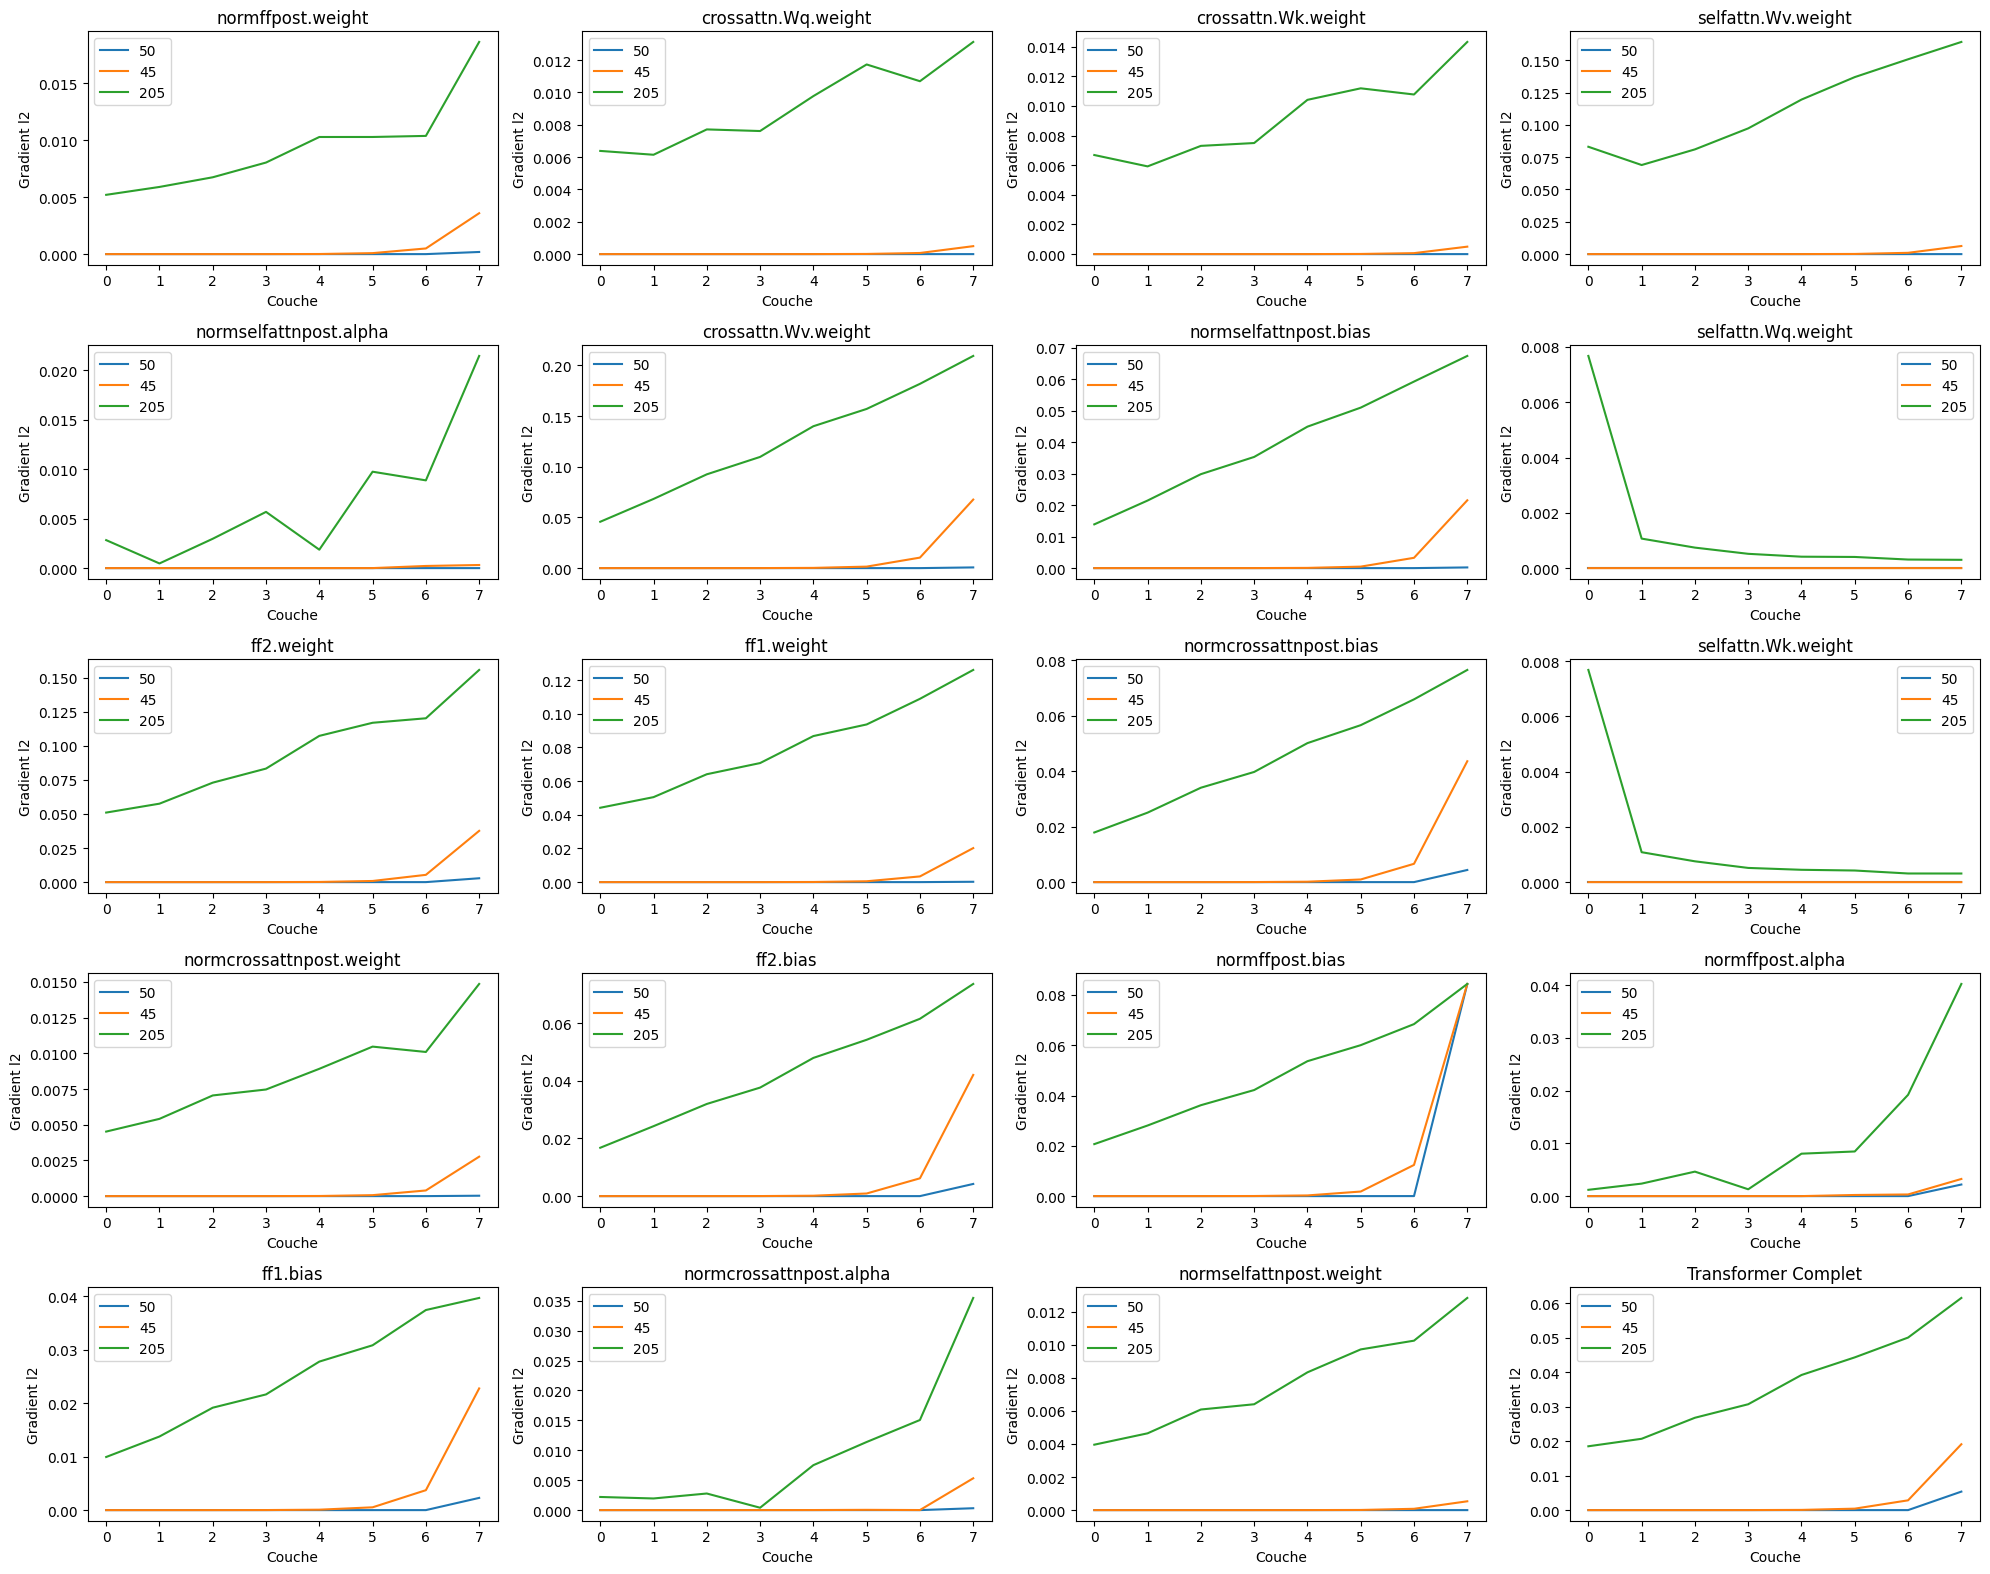

In [8]:
plot_multiple_grads(df.loc[df.query("Epoch==0 & exp_group!=2 & Position=='Post' & DyTfn=='Tanh'").groupby(["Alpha", "DyTfn"])['Eval Loss'].idxmin()])

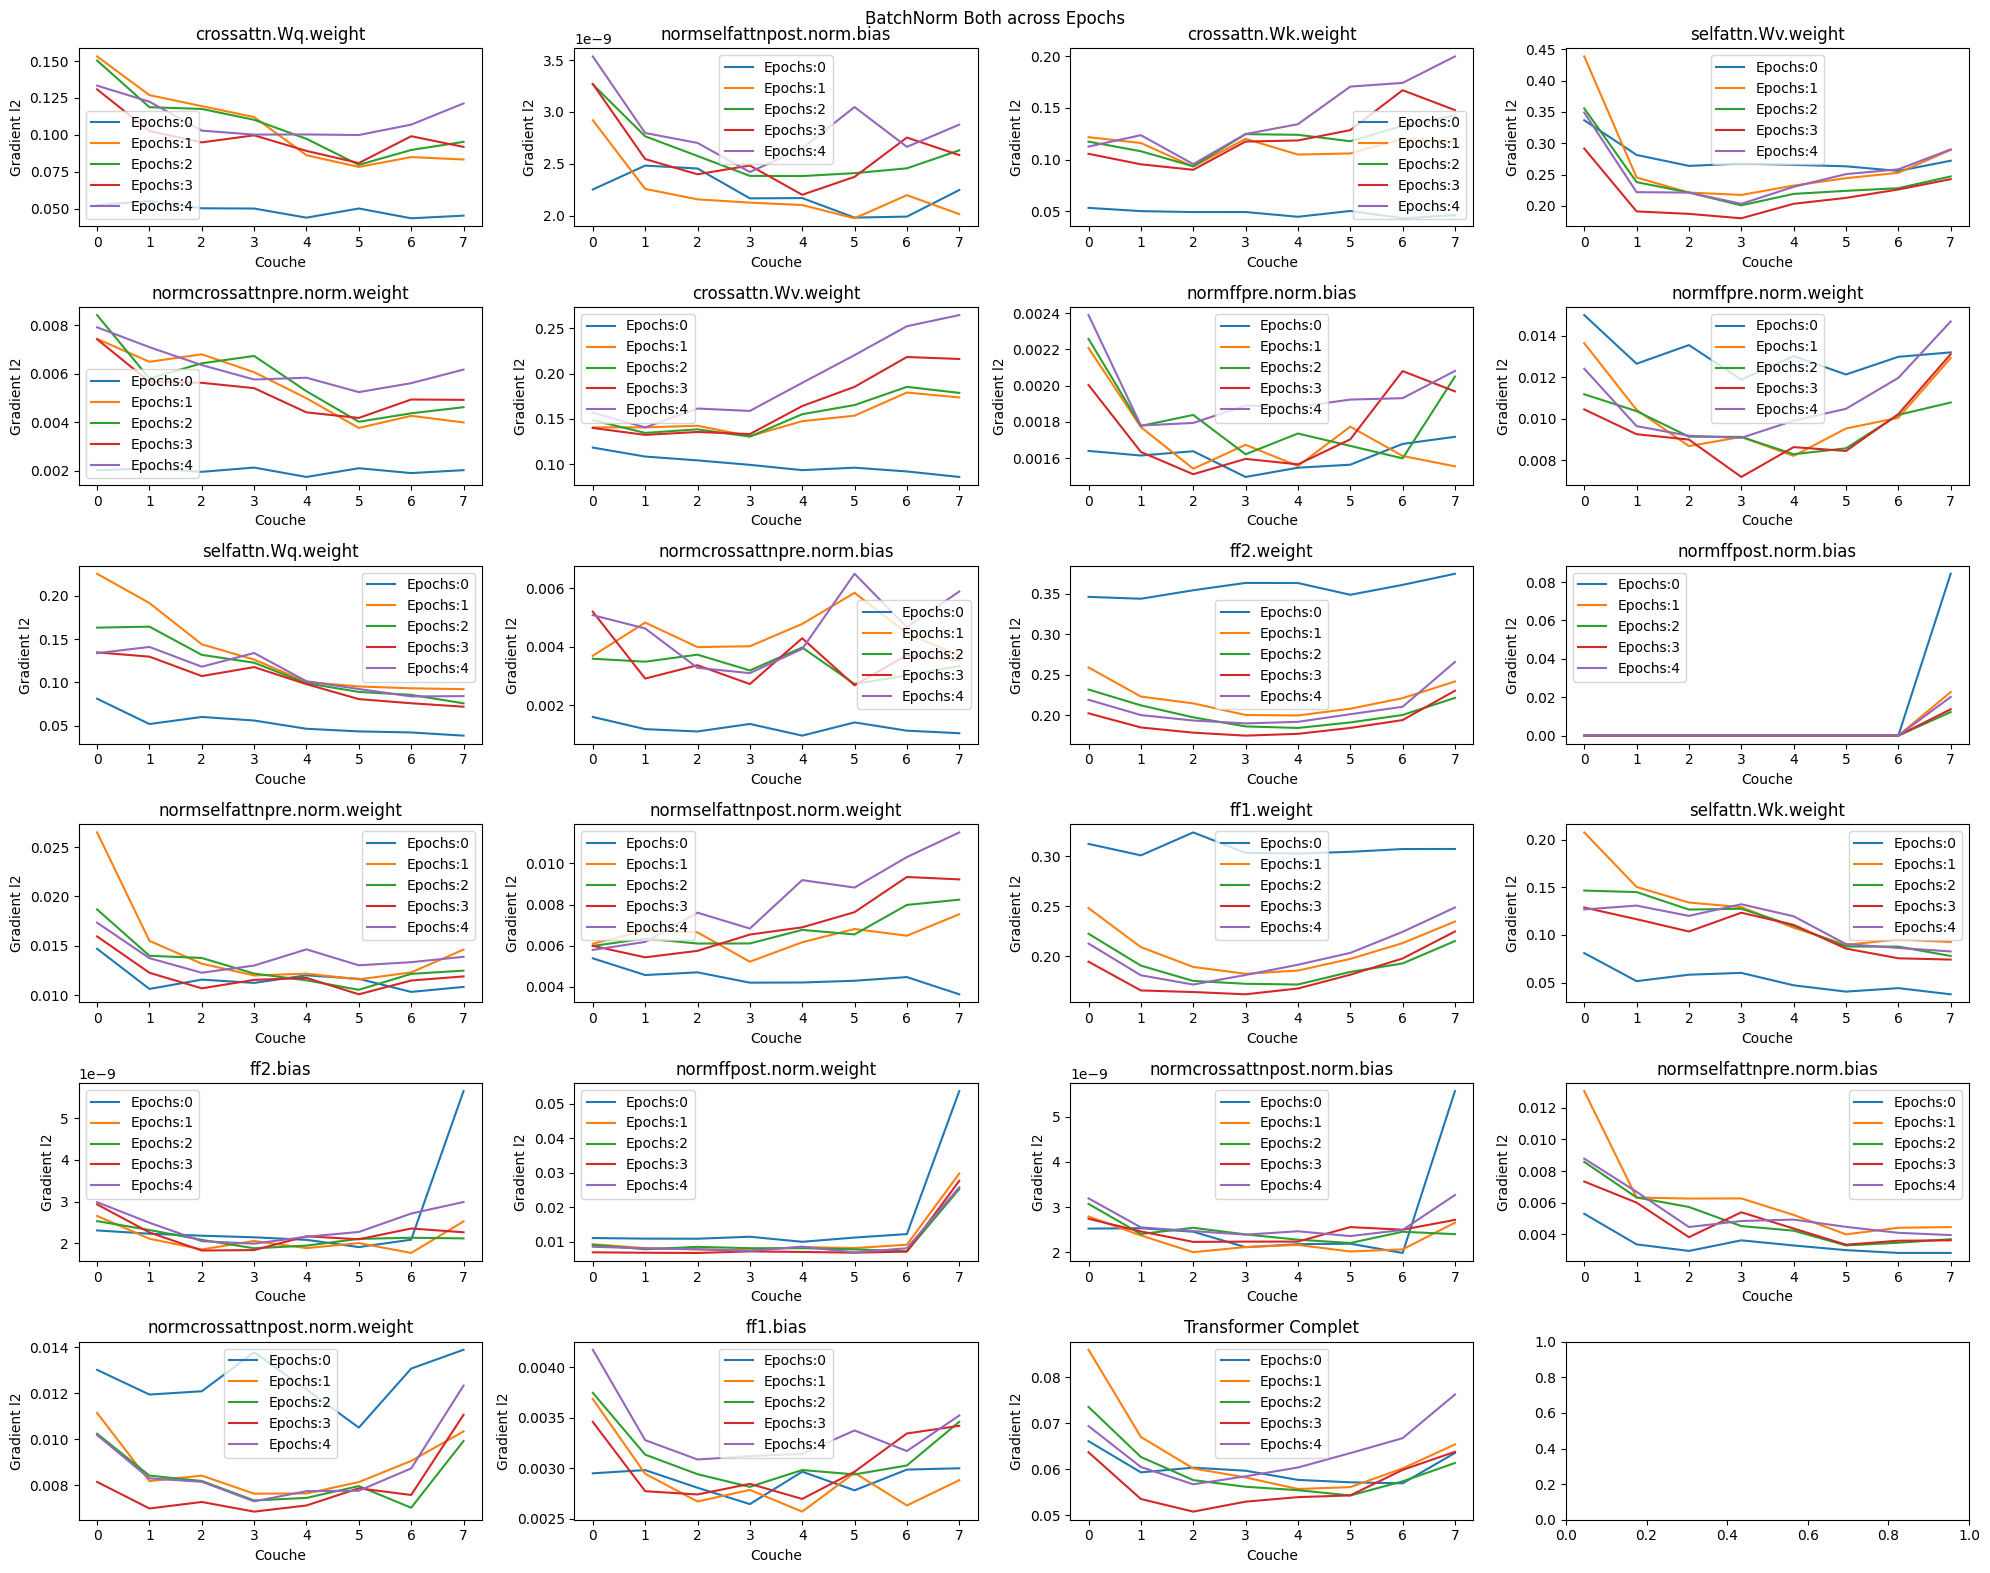

In [11]:
fig, axes = plot_multiple_grads(df.iloc[:5], name="BatchNorm Both across Epochs",name_fn=lambda x: f"Epochs:{x[1]["Epoch"]}")
plt.show()

In [12]:
df.query("Epoch==4 & exp_group!=2 & Layer=='DyT' & Position=='Post'")

,Layer,Position,Epoch,Train Loss,Eval Loss,Alpha,DyTfn,exp_group,lr,dim_hidden,Exp_full_name,Ground Truth,Prediction,Train Top-1,Train Top-5,Train Top-10,Eval Top-1,Eval Top-5,Eval Top-10,grads
49,DyT,Post,4,3.76,3.71,0.50,Tanh,1,0.0001,256.0,DyTPost,We're not really sure.,Nous Nous ne sommes pas pas.,0.38,0.57,0.64,0.37,0.57,0.64,"{'normffpost.weight': [0.018194695934653282, 0..."
54,DyT,Post,4,5.36,5.72,0.05,Tanh,1,0.0001,256.0,DyTPostAlpha=0.05,We're not really sure.,Nous Nous Nous Nous Nous Nous Nous Nous Nous N...,0.13,0.36,0.45,0.07,0.25,0.35,"{'normffpost.weight': [2.7113420880074115e-15,..."
59,DyT,Post,4,3.34,3.26,0.50,Hardtanh,1,0.0001,256.0,DyTPostHardtanh,We're not really sure.,Nous n'sommes pas pas pas.,0.44,0.62,0.68,0.44,0.62,0.68,"{'normffpost.weight': [0.008721855469048023, 0..."
64,DyT,Post,4,5.56,6.64,0.05,Hardtanh,1,0.0001,256.0,DyTPostHardtanhAlpha=0.05,We're not really sure.,Je Je Je Je Je Je Je Je Je Je Je Je Je Je Je J...,0.13,0.32,0.39,0.03,0.07,0.12,"{'normffpost.weight': [3.765547435698852e-16, ..."
69,DyT,Post,4,3.35,3.25,0.50,LeakyHardtanh,1,0.0001,256.0,DyTPostLeakyHardtanh,We're not really sure.,Nous ne sommes pas pas vraiment.,0.43,0.62,0.68,0.43,0.63,0.69,"{'normffpost.weight': [0.005625380203127861, 0..."
74,DyT,Post,4,5.55,6.67,0.05,LeakyHardtanh,1,0.0001,256.0,DyTPostLeakyHardtanhAlpha=0.05,We're not really sure.,Je Je Je Je Je Je Je Je Je Je Je Je Je Je Je J...,0.13,0.32,0.39,0.03,0.07,0.12,"{'normffpost.weight': [3.138201747737815e-16, ..."
209,DyT,Post,4,2.41,2.33,1.00,Tanh,3,0.0001,256.0,3-DyTPostAlpha=1.0,We're not really sure.,Nous ne sommes pas vraiment sûr.,0.56,0.75,0.79,0.57,0.75,0.80,"{'normffpost.weight': [0.01834114082157612, 0...."
214,DyT,Post,4,2.25,2.18,1.00,Hardtanh,3,0.0001,256.0,3-DyTPostHardtanhAlpha=1.0,We're not really sure.,Nous ne sommes pas vraiment sûr.,0.58,0.77,0.81,0.59,0.77,0.82,"{'normffpost.weight': [0.024726219475269318, 0..."
219,DyT,Post,4,2.26,2.18,1.00,LeakyHardtanh,3,0.0001,256.0,3-DyTPostLeakyHardtanhAlpha=1.0,We're not really sure.,Nous ne sommes pas vraiment sûr.,0.58,0.77,0.81,0.59,0.77,0.82,"{'normffpost.weight': [0.019075393676757812, 0..."


In [13]:
df.loc[df.query("Epoch==4 & exp_group==1").groupby(["Layer"])['Eval Loss'].idxmin()]


,Layer,Position,Epoch,Train Loss,Eval Loss,Alpha,DyTfn,exp_group,lr,dim_hidden,Exp_full_name,Ground Truth,Prediction,Train Top-1,Train Top-5,Train Top-10,Eval Top-1,Eval Top-5,Eval Top-10,grads
14,BatchNorm,Pre,4,1.70,1.69,NaN,None,1,0.0001,256.0,BatchNormPre,We're not really sure.,Nous ne sommes pas vraiment sûre.,0.65,0.84,0.88,0.65,0.84,0.88,"{'normffpre.norm.bias': [0.006446627900004387,..."
79,DyT,Pre,4,1.78,1.78,0.5,Tanh,1,0.0001,256.0,DyTPre,We're not really sure.,Nous ne sommes pas vraiment vraiment.,0.64,0.83,0.87,0.64,0.83,0.87,"{'crossattn.Wq.weight': [0.1223616898059845, 0..."
109,Identity,Both,4,1.74,1.71,NaN,None,1,0.0001,256.0,Identity,We're not really sure.,Nous ne sommes pas vraiment sûre.,0.64,0.83,0.87,0.65,0.84,0.87,"{'ff2.bias': [0.04844382032752037, 0.042340103..."
124,Layernorm,Pre,4,1.71,1.70,NaN,None,1,0.0001,256.0,LayernormPre,We're not really sure.,Nous ne sommes pas vraiment sûres.,0.65,0.84,0.88,0.65,0.84,0.88,"{'ff2.bias': [0.03647897392511368, 0.028255993..."
139,RMSNorm,Pre,4,1.71,1.70,NaN,None,1,0.0001,256.0,RMSNormPre,We're not really sure.,Nous ne sommes pas vraiment sûres.,0.65,0.84,0.88,0.65,0.84,0.88,"{'ff2.bias': [0.036276981234550476, 0.02746333..."


In [14]:
a = list(df.query("Epoch==4").groupby(["Layer"]).agg({"Eval Loss": np.min}).values.flatten())

/tmp/ipykernel_14848/3667664872.py:1: FutureWarning: The provided callable <function min at 0x764602895ee0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  a = list(df.query("Epoch==4").groupby(["Layer"]).agg({"Eval Loss": np.min}).values.flatten())


In [15]:
df[df["Eval Loss"].apply(lambda x : x in a)]

,Layer,Position,Epoch,Train Loss,Eval Loss,Alpha,DyTfn,exp_group,lr,dim_hidden,Exp_full_name,Ground Truth,Prediction,Train Top-1,Train Top-5,Train Top-10,Eval Top-1,Eval Top-5,Eval Top-10,grads
14,BatchNorm,Pre,4,1.70,1.69,NaN,None,1,0.0001,256.0,BatchNormPre,We're not really sure.,Nous ne sommes pas vraiment sûre.,0.65,0.84,0.88,0.65,0.84,0.88,"{'normffpre.norm.bias': [0.006446627900004387,..."
109,Identity,Both,4,1.74,1.71,NaN,None,1,0.0001,256.0,Identity,We're not really sure.,Nous ne sommes pas vraiment sûre.,0.64,0.83,0.87,0.65,0.84,0.87,"{'ff2.bias': [0.04844382032752037, 0.042340103..."
124,Layernorm,Pre,4,1.71,1.70,NaN,None,1,0.0001,256.0,LayernormPre,We're not really sure.,Nous ne sommes pas vraiment sûres.,0.65,0.84,0.88,0.65,0.84,0.88,"{'ff2.bias': [0.03647897392511368, 0.028255993..."
139,RMSNorm,Pre,4,1.71,1.70,NaN,None,1,0.0001,256.0,RMSNormPre,We're not really sure.,Nous ne sommes pas vraiment sûres.,0.65,0.84,0.88,0.65,0.84,0.88,"{'ff2.bias': [0.036276981234550476, 0.02746333..."
162,Layernorm,Post,2,1.77,1.71,NaN,None,2,0.0002,256.0,2-LayernormPost-lr=0.0002,I think this isn't correct.,Je ne pense pas que ce soit correct.,0.64,0.83,0.87,0.65,0.84,0.87,"{'normffpost.weight': [0.02205863781273365, 0...."
222,DyT,Pre,2,1.74,1.71,0.5,Tanh,3,0.0002,256.0,3-DyTPre-lr=0.0002,I think this isn't correct.,Je ne pense pas que ce soit correct.,0.64,0.83,0.87,0.64,0.84,0.88,"{'crossattn.Wq.weight': [0.10615569353103638, ..."
229,DyT,Pre,4,1.18,1.31,0.5,Tanh,3,0.0004,256.0,3-DyTPre-lr=0.0004,We're not really sure.,Nous ne sommes pas vraiment sûr.,0.72,0.90,0.93,0.70,0.89,0.92,"{'crossattn.Wq.weight': [0.07940035313367844, ..."
264,Layernorm,Pre,4,1.16,1.29,NaN,None,3,0.0004,256.0,3-LayernormPre-lr=0.0004,We're not really sure.,Nous ne sommes pas vraiment sûrs.,0.73,0.91,0.94,0.71,0.89,0.92,"{'ff2.bias': [0.021117636933922768, 0.01743428..."


In [16]:
df.query("Epoch==4 & exp_group==1").groupby(["Layer", "Position"]).agg({"Eval Loss": np.min})

/tmp/ipykernel_14848/2145597980.py:1: FutureWarning: The provided callable <function min at 0x764602895ee0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df.query("Epoch==4 & exp_group==1").groupby(["Layer", "Position"]).agg({"Eval Loss": np.min})


Eval Loss
Layer     Position           
BatchNorm Both           1.73
          Post           1.74
          Pre            1.69
DyT       Both           3.23
          Post           3.25
          Pre            1.78
Identity  Both           1.71
Layernorm Both           1.77
          Post           1.77
          Pre            1.70
RMSNorm   Both           1.77
          Post           1.78
          Pre            1.70